In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [5]:
# 1. Load train & test
train = pd.read_csv('../data/application_train.csv')
test  = pd.read_csv('../data/application_test.csv')

print(train.columns.tolist())
print(test.columns.tolist())

# Direct protected class features: 
['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Indirect proxies: 
['OWN_CAR_AGE','CNT_CHILDREN']

# Suspicious:
['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [7]:
# 2. Fix DAYS_EMPLOYED anomaly
train['DAYS_EMPLOYED_ANOM'] = (train['DAYS_EMPLOYED'] == 365243).astype(int)
test['DAYS_EMPLOYED_ANOM']  = (test['DAYS_EMPLOYED'] == 365243).astype(int)

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({365243: np.nan})
test['DAYS_EMPLOYED']  = test['DAYS_EMPLOYED'].replace({365243: np.nan})

In [8]:
# 3. Drop the same columns from train & test BEFORE encoding
cols_to_drop = [
    "SK_ID_CURR",
    "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START",
    "WALLSMATERIAL_MODE", "N"
]

# biased_cols = ['CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE','CNT_CHILDREN']
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

train.drop(columns=cols_to_drop, errors="ignore", inplace=True)
test.drop(columns=cols_to_drop, errors="ignore", inplace=True)


In [9]:
def preprocess_and_encode(train_df, test_df, target_col="TARGET"):
    """
    Returns:
        X_enc, X_test_enc, y, feature_names, ct
    """
    import pandas as pd
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

    # 1. Split target
    y = train_df[target_col]
    train_X = train_df.drop(columns=[target_col])

    # 2. Align train/test
    train_X, test_X = train_X.align(test_df, join="inner", axis=1)

    # 3. Identify categorical columns
    one_hot_cols = [
        'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
        'EMERGENCYSTATE_MODE'
    ]

    # Keep only those present
    one_hot_cols = [c for c in one_hot_cols if c in train_X.columns]

    # 4. Split binary vs multi
    binary_cats = []
    multi_cats = []

    for col in one_hot_cols:
        unique_vals = train_X[col].dropna().unique()
        if len(unique_vals) <= 2:
            binary_cats.append(col)
        else:
            multi_cats.append(col)

    # 5. Build ColumnTransformer
    ct = ColumnTransformer(
        transformers=[
            ("binary", OrdinalEncoder(), binary_cats),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), multi_cats),
        ],
        remainder="passthrough"
    )

    # 6. Fit/transform
    X_enc = ct.fit_transform(train_X)
    X_test_enc = ct.transform(test_X)

    feature_names = ct.get_feature_names_out()

    return X_enc, X_test_enc, y, feature_names, ct

def make_numeric_for_corr(df):
    df_corr = df.copy()
    for col in df_corr.columns:
        # Convert objects/categories to integer codes for correlation
        if df_corr[col].dtype == 'object' or str(df_corr[col].dtype).startswith('category'):
            df_corr[col] = df_corr[col].astype('category').cat.codes
    return df_corr



In [10]:
# Prepare biased versions (original)
train_biased = train.copy()
test_biased = test.copy()

biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']

# Prepare unbiased versions
# train_unbiased = train.copy()
# test_unbiased = test.copy()

train_corr = make_numeric_for_corr(train)
corr = train_corr.corr()

valid_bcols = [b for b in biased_cols if b in corr.columns]

corr_sub = corr[valid_bcols]

corr['CODE_GENDER'].sort_values(ascending=False)[:10]

cutoff = 0.1

biased_proxies = []
proxy_features = set()
proxy_features = proxy_features - set(valid_bcols)


for bcol in valid_bcols:
    # Identify features whose absolute correlation exceeds the cutoff
    high_corr_features = corr.index[corr[bcol].abs() > cutoff].tolist()
    
    # Add them to the proxy set
    proxy_features.update(high_corr_features)

proxy_features = proxy_features - set(valid_bcols)

for bcol in valid_bcols:
    subset = corr[bcol].abs().sort_values(ascending=False)
    subset = subset.drop(labels=bcol, errors='ignore')
    biased_proxies.append(subset)

biased_table = pd.concat(biased_proxies, axis=1)
biased_table.columns = valid_bcols        # MATCHING LENGTH
biased_table = biased_table.fillna(0)
biased_table.sort_values(by=valid_bcols, ascending=False, inplace=True)

print(biased_table.head())

print(proxy_features)
print(f"{len(proxy_features)} proxy features identified.")
print(f"This is {(len(proxy_features) / len(train_biased.columns)) * 100:.2f}% of the total.")

                    CODE_GENDER  DAYS_BIRTH
FLAG_OWN_CAR           0.345833    0.129879
EXT_SOURCE_1           0.306700    0.600610
FLAG_DOCUMENT_8        0.249767    0.113243
ORGANIZATION_TYPE      0.163879    0.395304
DAYS_EMPLOYED_ANOM     0.157318    0.619947
{'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS', 'EXT_SOURCE_1', 'FLAG_WORK_PHONE', 'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_6', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_8', 'CNT_CHILDREN', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_3', 'DAYS_EMPLOYED_ANOM', 'OCCUPATION_TYPE', 'DAYS_ID_PUBLISH', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED', 'NAME_HOUSING_TYPE'}
26 proxy features identified.
This is 21.85% of the total.


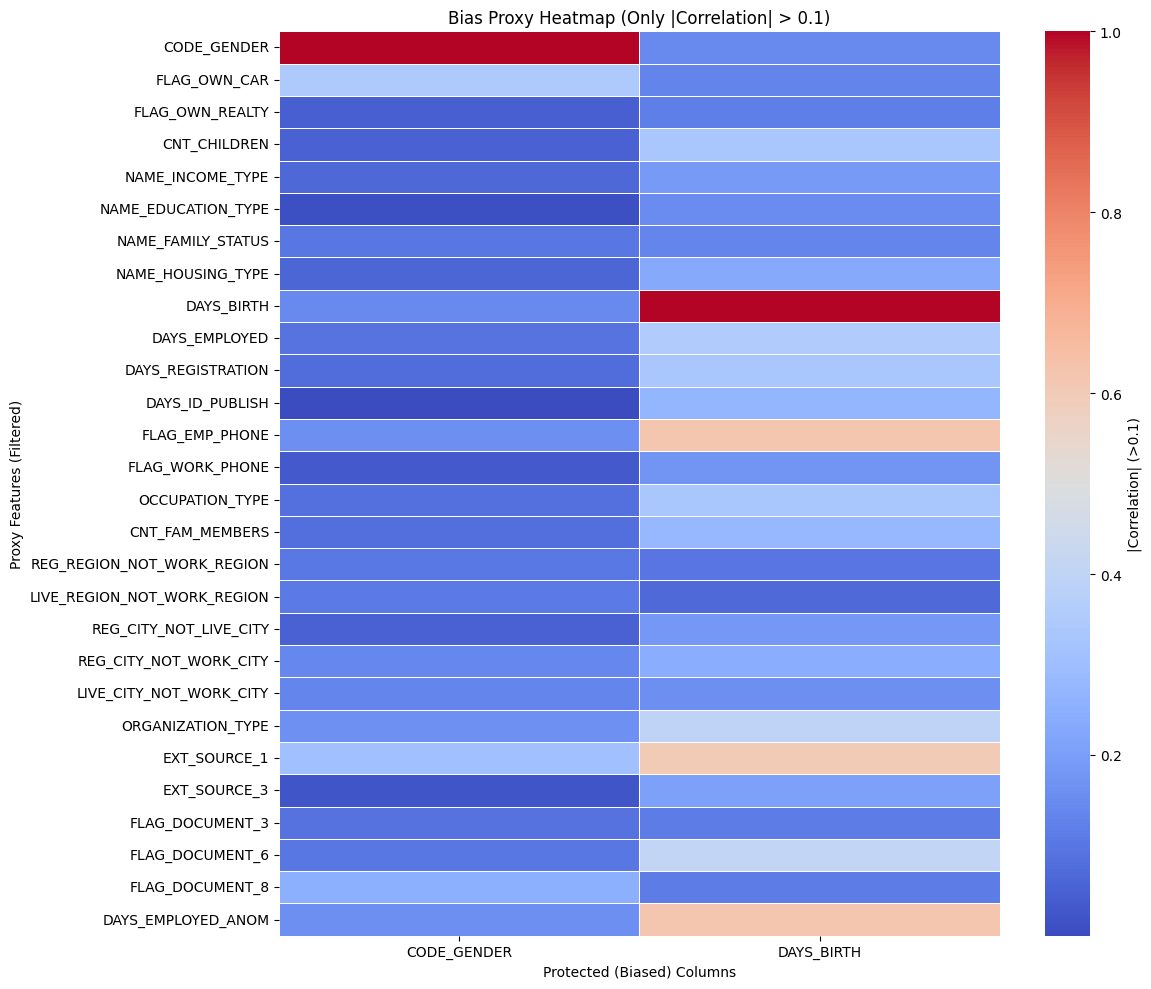

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# corr_sub = corr[valid_bcols]  # Ensure corr_sub already exists

# 1. Identify features with correlation > cutoff with ANY biased column
mask = corr_sub.abs().max(axis=1) > cutoff

# 2. Filter correlation matrix to only proxy features
corr_filtered = corr_sub[mask]

# 3. Plot heatmap of only high-correlation proxy features
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_filtered.abs(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    cbar_kws={'label': f'|Correlation| (>{cutoff})'}
)

plt.title(f"Bias Proxy Heatmap (Only |Correlation| > {cutoff})")
plt.xlabel("Protected (Biased) Columns")
plt.ylabel("Proxy Features (Filtered)")
plt.tight_layout()
plt.show()


So there are a lot of features that are correlated with gender and age. However, if we were to drop all of these features, our model would not be very accurate. To solve this problem, we will run an overlap test to identify features that can cause a positivity violation with our protected classes of gender and age. 

In [12]:
#  0. Convert categorical to numeric for correlation & overlap 
train_corr = make_numeric_for_corr(train)

#  1. Define protected variables 
biased_cols = ['CODE_GENDER', 'DAYS_BIRTH']   # core sensitive features

#  2. Create Gender Binary (0 = M, 1 = F) 
train['_GENDER_BIN'] = (train['CODE_GENDER'] == 'F').astype(int)

#  3. Create Age Group Bins for positivity testing 
# DAYS_BIRTH is negative in Home Credit, so invert it:
train['_AGE'] = -train['DAYS_BIRTH']

# Use quartiles for overlap testing
train['_AGE_BIN'] = pd.qcut(train['_AGE'], q=4, labels=False, duplicates='drop')

#  4. Define candidate (non-protected) features 
protected_vars = biased_cols + ['_GENDER_BIN', '_AGE_BIN', '_AGE']

candidate_features = [
    c for c in train.columns 
    if c not in protected_vars and c not in ['TARGET']
]

print("Number of candidate features:", len(candidate_features))


#  5. POSITIVITY TEST FOR GENDER (M vs F) 

female_unique = train.loc[train['_GENDER_BIN'] == 1, candidate_features].nunique()
viol_female = list(female_unique[female_unique < 2].index)

male_unique   = train.loc[train['_GENDER_BIN'] == 0, candidate_features].nunique()
viol_male = list(male_unique[male_unique < 2].index)

print("\n Gender Positivity Violations ")
print("Violates for FEMALES:", viol_female)
print("Violates for MALES:", viol_male)


#  6. POSITIVITY TEST FOR AGE (each age bin) 

viol_age_bins = {}

for age_group in sorted(train['_AGE_BIN'].dropna().unique()):
    gmask = train['_AGE_BIN'] == age_group
    nunique_vals = train.loc[gmask, candidate_features].nunique()
    viol = list(nunique_vals[nunique_vals < 2].index)
    viol_age_bins[int(age_group)] = viol

print("\n Age Positivity Violations ")
for k, v in viol_age_bins.items():
    print(f"Age bin {k}: {v}")


#  7. Combine all violations 

positivity_violations = set(viol_female) | set(viol_male)

for vlist in viol_age_bins.values():
    positivity_violations |= set(vlist)

positivity_violations = sorted(positivity_violations)

print("\n ALL Positivity Violations Across Gender + Age ")
print(positivity_violations)


Number of candidate features: 116

 Gender Positivity Violations 
Violates for FEMALES: ['FLAG_MOBIL']
Violates for MALES: []

 Age Positivity Violations 
Age bin 0: ['FLAG_DOCUMENT_12']
Age bin 1: ['FLAG_MOBIL']
Age bin 2: ['FLAG_MOBIL']
Age bin 3: ['FLAG_MOBIL', 'FLAG_DOCUMENT_12']

 ALL Positivity Violations Across Gender + Age 
['FLAG_DOCUMENT_12', 'FLAG_MOBIL']


This is a very interesting result. The test we just ran studied the dataset for positivity (overlap) violations. In the certain protected groups, these two features showed no variability. For females for example, the FLAG_MOBIL variable always has the same result. This flag also presents itself as an age-related bias. With a lack of variability, these features still reinforce structural bias and undermine the fairness adjusted modeling technique. 

In [13]:
# Last step: Drop all the biased columns from the unbiased set

all_biased_to_drop = set(biased_cols) | set(proxy_features) | set(positivity_violations)

print("Dropping these biased features:", all_biased_to_drop)

train_unbiased = train.drop(columns=all_biased_to_drop)
test_unbiased = test.drop(columns=all_biased_to_drop)

print(f"Dropped {len(all_biased_to_drop)} features. This is {(len(all_biased_to_drop) / len(train_biased.columns)) * 100:.2f}% of the original.")


Dropping these biased features: {'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS', 'EXT_SOURCE_1', 'FLAG_WORK_PHONE', 'FLAG_MOBIL', 'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_6', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_8', 'CNT_CHILDREN', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_3', 'DAYS_EMPLOYED_ANOM', 'FLAG_DOCUMENT_12', 'OCCUPATION_TYPE', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'REG_REGION_NOT_WORK_REGION', 'CODE_GENDER', 'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_3', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_EMP_PHONE', 'DAYS_EMPLOYED', 'NAME_HOUSING_TYPE'}
Dropped 30 features. This is 25.21% of the original.


It is important to note that most columns dropped here explode the dimensionality when the data is one-hot encoded. 

In [14]:
# Run biased pipeline
X_biased_enc, X_test_biased_enc, y_biased, feature_names_biased, ct_biased = \
    preprocess_and_encode(train_biased, test_biased)

print("Biased train shape:", X_biased_enc.shape)
print("Biased test shape:", X_test_biased_enc.shape)

# Run unbiased pipeline
X_unbiased_enc, X_test_unbiased_enc, y_unbiased, feature_names_unbiased, ct_unbiased = \
    preprocess_and_encode(train_unbiased, test_unbiased)

print("Unbiased train shape:", X_unbiased_enc.shape)
print("Unbiased test shape:", X_test_unbiased_enc.shape)

Biased train shape: (307511, 230)
Biased test shape: (48744, 230)
Unbiased train shape: (307511, 102)
Unbiased test shape: (48744, 102)


# Training Biased and Unbiased Models

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
import seaborn as sns
from sklearn.model_selection import cross_val_predict

def scores(y_true, y_pred, y_pred_proba, title="Model Evaluation"):
    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred)

    # Print metric summary
    print(f"{title}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC-AUC:", auc)
    print("\nConfusion Matrix (Raw Values):\n", cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Running 5-fold logistic regression CV...

Fold 1 — train: 246008, val: 61503
Fold 2 — train: 246009, val: 61502
Fold 3 — train: 246009, val: 61502
Fold 4 — train: 246009, val: 61502
Fold 5 — train: 246009, val: 61502

CV completed in 717.3 seconds

Logistic Regression CV Scores
Model Evaluation
Accuracy: 0.6877510072810403
Precision: 0.16035836617084412
Recall: 0.677019133937563
F1: 0.25929925791073327
ROC-AUC: 0.746453832509133

Confusion Matrix (Raw Values):
 [[194684  88002]
 [  8018  16807]]


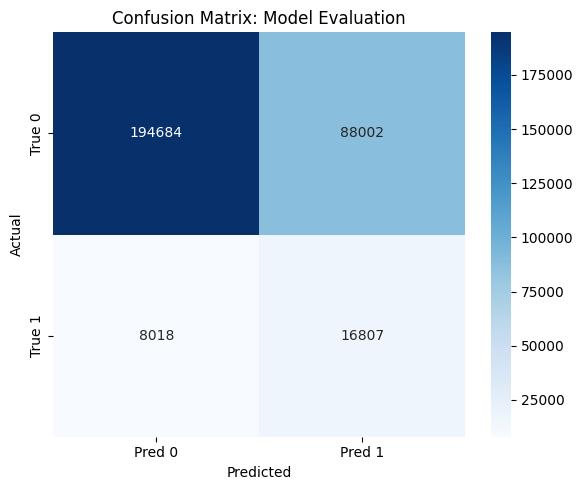


Training final model on ALL training data...

Top 20 Logistic Regression Features:
remainder__AMT_CREDIT                            0.922432
onehot__NAME_INCOME_TYPE_Working                 0.281546
remainder__YEARS_BUILD_AVG                       0.272056
remainder__BASEMENTAREA_MEDI                     0.257162
onehot__ORGANIZATION_TYPE_XNA                    0.207518
remainder__DAYS_EMPLOYED_ANOM                    0.207518
remainder__LIVINGAPARTMENTS_MEDI                 0.205306
onehot__NAME_INCOME_TYPE_Commercial associate    0.204312
remainder__OBS_30_CNT_SOCIAL_CIRCLE              0.202431
remainder__COMMONAREA_AVG                        0.161847
remainder__REGION_RATING_CLIENT_W_CITY           0.136496
remainder__FLAG_DOCUMENT_3                       0.136321
remainder__DAYS_EMPLOYED                         0.134429
remainder__ELEVATORS_MODE                        0.129557
remainder__LIVINGAREA_AVG                        0.128054
onehot__NAME_INCOME_TYPE_State servant        

In [16]:
# ===============================
#   LOGISTIC REGRESSION (ROBUST CV LOOP)
# ===============================

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import time

# ---------------------------------------------------
# 1) Create pipeline: Impute → Scale → Logistic Reg
# ---------------------------------------------------
pipe_log = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="liblinear",       # stable & works well
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    )),
])

# ---------------------------------------------------
# 2) Prepare data for CV
# ---------------------------------------------------
X = X_biased_enc
y = y_biased

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n = len(y)
oof_pred = np.zeros(n, dtype=int)
oof_proba = np.zeros(n, dtype=float)

print("Running 5-fold logistic regression CV...\n")
start = time.time()

# ---------------------------------------------------
# 3) Manual CV Loop (prevents timeout)
# ---------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    print(f"Fold {fold} — train: {len(train_idx)}, val: {len(val_idx)}")

    if hasattr(X, "iloc"):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    else:
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

    # Fit model on fold
    pipe_log.fit(X_tr, y_tr)

    # Predict on validation split
    preds = pipe_log.predict(X_val)
    probs = pipe_log.predict_proba(X_val)[:, 1]

    # Store OOF predictions
    oof_pred[val_idx] = preds
    oof_proba[val_idx] = probs

print("\nCV completed in %.1f seconds" % (time.time() - start))

# ---------------------------------------------------
# 4) Evaluate cross-validated scores
# ---------------------------------------------------
print("\nLogistic Regression CV Scores")
scores(y, oof_pred, oof_proba)

# ---------------------------------------------------
# 5) Fit final model on full training data
# ---------------------------------------------------
print("\nTraining final model on ALL training data...")
pipe_log.fit(X, y)

# ---------------------------------------------------
# 6) Predict on real test data
# ---------------------------------------------------
logreg_test_pred = pipe_log.predict_proba(X_test_biased_enc)[:, 1]

# ---------------------------------------------------
# 7) Feature importance (coefficients)
# ---------------------------------------------------
coefs = pipe_log.named_steps["clf"].coef_[0]
feat_names = list(feature_names_biased)

logreg_importance = pd.Series(coefs, index=feat_names).sort_values(ascending=False)

print("\nTop 20 Logistic Regression Features:")
print(logreg_importance.head(20))


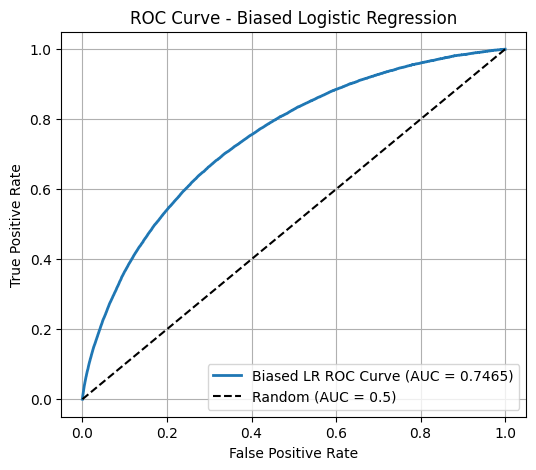

In [29]:
# ===============================
#   ROC CURVE FOR LOGISTIC REGRESSION
# ===============================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y = true labels
# oof_proba = cross-validated predicted probabilities from your CV loop

# ---- Compute ROC ----
fpr, tpr, thresholds = roc_curve(y, oof_proba)
roc_auc = auc(fpr, tpr)

# ---- Plot ----
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Biased LR ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Biased Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


Running 5-fold logistic regression CV...

Fold 1 — train: 246008, val: 61503
Fold 2 — train: 246009, val: 61502
Fold 3 — train: 246009, val: 61502
Fold 4 — train: 246009, val: 61502
Fold 5 — train: 246009, val: 61502

CV completed in 717.3 seconds

Logistic Regression CV Scores
Model Evaluation
Accuracy: 0.6877510072810403
Precision: 0.16035836617084412
Recall: 0.677019133937563
F1: 0.25929925791073327
ROC-AUC: 0.746453832509133

Confusion Matrix (Raw Values):
 [[194684  88002]
 [  8018  16807]]


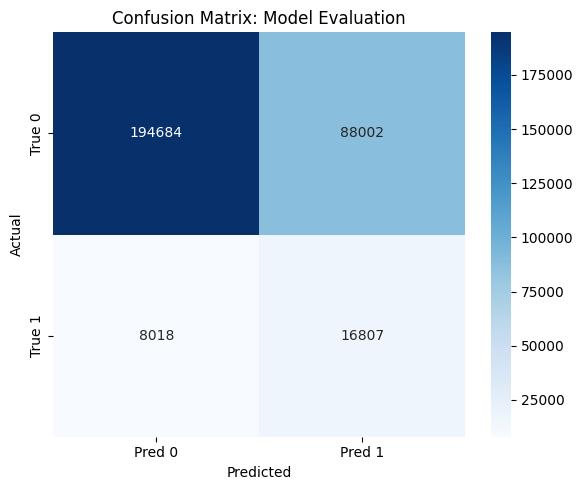


Training final model on ALL training data...

Top 20 Logistic Regression Features:
remainder__AMT_CREDIT                            0.922432
onehot__NAME_INCOME_TYPE_Working                 0.281546
remainder__YEARS_BUILD_AVG                       0.272056
remainder__BASEMENTAREA_MEDI                     0.257162
onehot__ORGANIZATION_TYPE_XNA                    0.207518
remainder__DAYS_EMPLOYED_ANOM                    0.207518
remainder__LIVINGAPARTMENTS_MEDI                 0.205306
onehot__NAME_INCOME_TYPE_Commercial associate    0.204312
remainder__OBS_30_CNT_SOCIAL_CIRCLE              0.202431
remainder__COMMONAREA_AVG                        0.161847
remainder__REGION_RATING_CLIENT_W_CITY           0.136496
remainder__FLAG_DOCUMENT_3                       0.136321
remainder__DAYS_EMPLOYED                         0.134429
remainder__ELEVATORS_MODE                        0.129557
remainder__LIVINGAREA_AVG                        0.128054
onehot__NAME_INCOME_TYPE_State servant        

In [ ]:
# ===============================
#   LOGISTIC REGRESSION (ROBUST CV LOOP)
# ===============================

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import time

# ---------------------------------------------------
# 1) Create pipeline: Impute → Scale → Logistic Reg
# ---------------------------------------------------
pipe_log = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="liblinear",       # stable & works well
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    )),
])

# ---------------------------------------------------
# 2) Prepare data for CV
# ---------------------------------------------------
X = X_biased_enc
y = y_biased

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n = len(y)
oof_pred = np.zeros(n, dtype=int)
oof_proba = np.zeros(n, dtype=float)

print("Running 5-fold logistic regression CV...\n")
start = time.time()

# ---------------------------------------------------
# 3) Manual CV Loop (prevents timeout)
# ---------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    print(f"Fold {fold} — train: {len(train_idx)}, val: {len(val_idx)}")

    if hasattr(X, "iloc"):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    else:
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

    # Fit model on fold
    pipe_log.fit(X_tr, y_tr)

    # Predict on validation split
    preds = pipe_log.predict(X_val)
    probs = pipe_log.predict_proba(X_val)[:, 1]

    # Store OOF predictions
    oof_pred[val_idx] = preds
    oof_proba[val_idx] = probs

print("\nCV completed in %.1f seconds" % (time.time() - start))

# ---------------------------------------------------
# 4) Evaluate cross-validated scores
# ---------------------------------------------------
print("\nLogistic Regression CV Scores")
scores(y, oof_pred, oof_proba)

# ---------------------------------------------------
# 5) Fit final model on full training data
# ---------------------------------------------------
print("\nTraining final model on ALL training data...")
pipe_log.fit(X, y)

# ---------------------------------------------------
# 6) Predict on real test data
# ---------------------------------------------------
logreg_test_pred = pipe_log.predict_proba(X_test_biased_enc)[:, 1]

# ---------------------------------------------------
# 7) Feature importance (coefficients)
# ---------------------------------------------------
coefs = pipe_log.named_steps["clf"].coef_[0]
feat_names = list(feature_names_biased)

logreg_importance = pd.Series(coefs, index=feat_names).sort_values(ascending=False)

print("\nTop 20 Logistic Regression Features:")
print(logreg_importance.head(20))


Model Evaluation (Unbiased – Logistic Regression)
Accuracy: 0.652939244449792
Precision: 0.13332079729221513
Recall: 0.5997583081570997
F1: 0.21814905166919407
ROC-AUC: 0.6769146234718213

Confusion Matrix (Raw Values):
 [[185897  96789]
 [  9936  14889]]


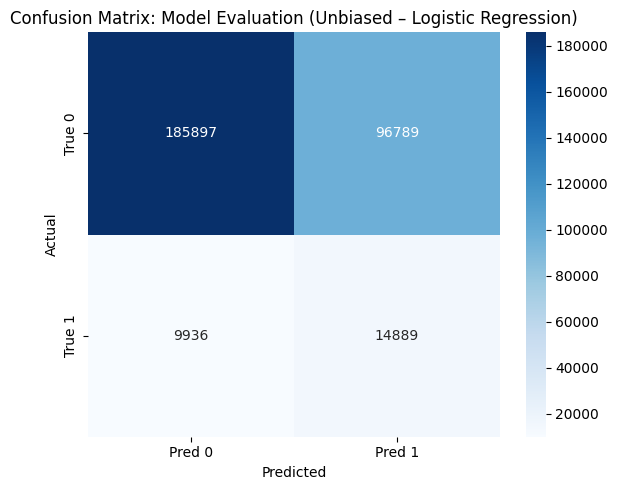


Top 20 Logistic Regression Features (Unbiased – Sklearn):
remainder__AMT_CREDIT                     0.994651
remainder__YEARS_BUILD_AVG                0.251941
remainder__BASEMENTAREA_MEDI              0.223984
remainder__LIVINGAPARTMENTS_MEDI          0.181707
remainder__OBS_30_CNT_SOCIAL_CIRCLE       0.161251
remainder__AMT_ANNUITY                    0.154371
remainder__COMMONAREA_AVG                 0.154161
remainder__REGION_RATING_CLIENT_W_CITY    0.124212
remainder__DAYS_LAST_PHONE_CHANGE         0.117899
remainder__ELEVATORS_MODE                 0.116311
remainder__NONLIVINGAPARTMENTS_MODE       0.106861
remainder__ENTRANCES_AVG                  0.098899
remainder__FLOORSMIN_MEDI                 0.097201
remainder__YEARS_BEGINEXPLUATATION_AVG    0.078987
remainder__COMMONAREA_MODE                0.067812
remainder__DEF_30_CNT_SOCIAL_CIRCLE       0.067379
remainder__APARTMENTS_AVG                 0.064211
remainder__LANDAREA_AVG                   0.061128
remainder__AMT_INCOME_T

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

label_col = "TARGET"

# 1) Median imputation (fit on train, apply to test)
imputer_unbiased = SimpleImputer(strategy="median")
X_unbiased_enc_imputed = imputer_unbiased.fit_transform(X_unbiased_enc)
X_test_unbiased_enc_imputed = imputer_unbiased.transform(X_test_unbiased_enc)

# 2) Logistic Regression (sklearn)
logreg_unbiased = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    ))
])

# 3) Cross-validated predictions (5-fold)
logreg_unbiased_pred = cross_val_predict(
    logreg_unbiased,
    X_unbiased_enc_imputed,
    y_unbiased,
    cv=5,
    method="predict"
)

logreg_unbiased_pred_proba = cross_val_predict(
    logreg_unbiased,
    X_unbiased_enc_imputed,
    y_unbiased,
    cv=5,
    method="predict_proba"
)[:, 1]

# 4) Evaluate using your existing scores() function
scores(
    y_unbiased,
    logreg_unbiased_pred,
    logreg_unbiased_pred_proba,
    title="Model Evaluation (Unbiased – Logistic Regression)"
)

# 5) Fit final model on ALL unbiased training data
logreg_unbiased.fit(X_unbiased_enc_imputed, y_unbiased)

# 6) Predict on unbiased test data
logreg_unbiased_test_pred = logreg_unbiased.predict_proba(X_test_unbiased_enc_imputed)[:, 1]

# 7) Feature importance (coefficients)
# Extract coefficients from the logistic regression step in the pipeline
coefs = logreg_unbiased.named_steps["clf"].coef_[0]

logreg_unbiased_importance = pd.Series(
    coefs,
    index=feature_names_unbiased
).sort_values(ascending=False)

print("\nTop 20 Logistic Regression Features (Unbiased – Sklearn):")
print(logreg_unbiased_importance.head(20))


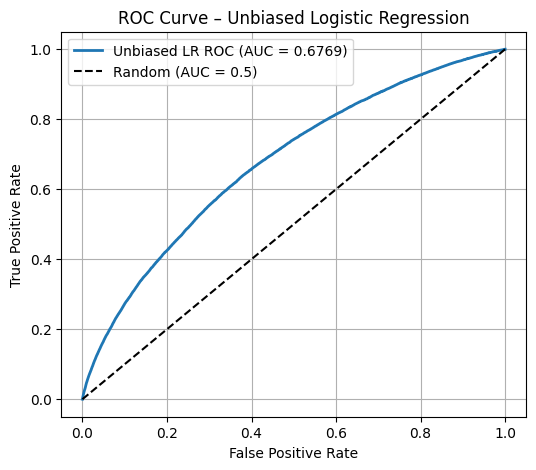

In [27]:
# ===============================
#   ROC CURVE FOR UNBIASED LOGISTIC REGRESSION
# ===============================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_unbiased  = true labels for unbiased dataset
# logreg_unbiased_pred_proba = CV predicted probabilities (from LR model)

# ---- Compute ROC ----
fpr_u, tpr_u, thresholds_u = roc_curve(y_unbiased, logreg_unbiased_pred_proba)
roc_auc_u = auc(fpr_u, tpr_u)

# ---- Plot ----
plt.figure(figsize=(6, 5))
plt.plot(fpr_u, tpr_u, label=f"Unbiased LR ROC (AUC = {roc_auc_u:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Unbiased Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


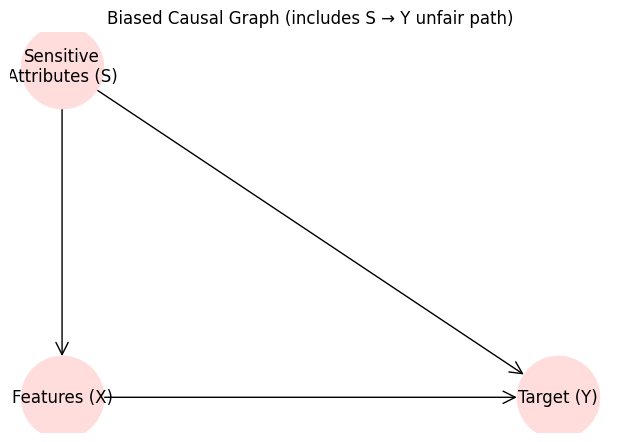

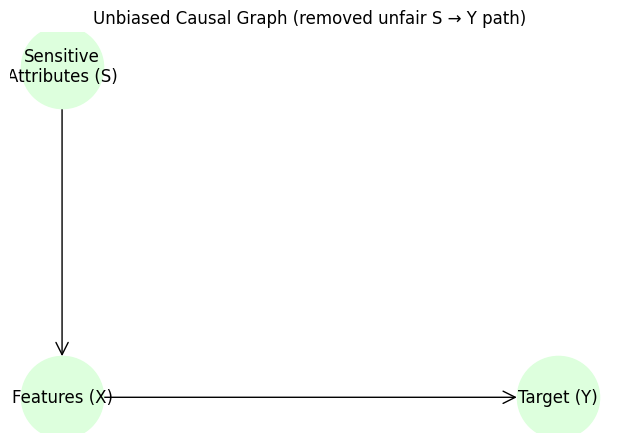

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# ---- BIASED GRAPH ----
G = nx.DiGraph()
G.add_edges_from([
    ("Sensitive\nAttributes (S)", "Features (X)"),
    ("Features (X)", "Target (Y)"),
    ("Sensitive\nAttributes (S)", "Target (Y)")  # unfair edge
])

pos = {
    "Sensitive\nAttributes (S)": (0, 1),
    "Features (X)": (0, 0),
    "Target (Y)": (1, 0),
}

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_size=3500,
        node_color="#ffdddd", arrowsize=22, arrowstyle="->")
plt.title("Biased Causal Graph (includes S → Y unfair path)")
plt.show()


# ---- UNBIASED GRAPH ----
G2 = nx.DiGraph()
G2.add_edges_from([
    ("Sensitive\nAttributes (S)", "Features (X)"),
    ("Features (X)", "Target (Y)")
])

plt.figure(figsize=(6, 4))
nx.draw(G2, pos, with_labels=True, node_size=3500,
        node_color="#ddffdd", arrowsize=22, arrowstyle="->")
plt.title("Unbiased Causal Graph (removed unfair S → Y path)")
plt.show()


What I will eventually do is quantify how much the feature input weights in the model that has more features has on the output by directly comparing the two models. I will then need a vector which quantifies and tells the BIASED model how to adjust the weight of the input features to be unbiased, and the same for the inverse task (make an unbiased model biased). 